In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import math
import json

In [11]:
df = pd.read_csv('ITMG.JK.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,12/18/2007,16000,19600,16000,19600,3455.358154,45450000
1,12/19/2007,19000,20100,18900,19000,3349.582275,12470000
2,12/26/2007,19000,19000,19000,19000,3349.582275,0
3,12/27/2007,18550,19050,18600,19000,3349.582275,4807000
4,12/28/2007,19000,19050,18550,18900,3331.952393,1593000
...,...,...,...,...,...,...,...
4104,8/27/2024,27150,27200,26800,27000,27000.000000,964900
4105,8/28/2024,27000,27225,27000,27225,27225.000000,1236800
4106,8/29/2024,27225,27750,27100,27175,27175.000000,2526100
4107,8/30/2024,27175,27350,27075,27225,27225.000000,1453400


In [12]:
features = ['Open', 'High', 'Low', 'Close']
target = 'Close'

df = df.dropna()

X = df[features].values
y = df[target].values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")


Training data shape: (3287, 4), (3287,)
Test data shape: (822, 4), (822,)


In [14]:
x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1,1))

In [15]:
import numpy as np

def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)

    x_ = np.array(x_, dtype=np.float32)
    y_ = np.array(y_, dtype=np.float32)
    y_gan = np.array(y_gan, dtype=np.float32)

    return x_, y_, y_gan


In [16]:
window_size = 10
train_x_slide, train_y_slide, train_y_gan = sliding_window(X_train_scaled, y_train_scaled, window_size)
test_x_slide, test_y_slide, test_y_gan = sliding_window(X_test_scaled, y_test_scaled, window_size)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')

train_x: (3277, 10, 4) train_y: (3277, 1) train_y_gan: (3277, 11, 1)
test_x: (812, 10, 4) test_y: (812, 1) test_y_gan: (812, 11, 1)


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, Model

@tf.keras.utils.register_keras_serializable()
class TCNGenerator(tf.keras.Model):
    def __init__(self, input_size, **kwargs):
        super(TCNGenerator, self).__init__()
        self.input_size = input_size

        self.conv1 = layers.Conv1D(filters=64, kernel_size=5, dilation_rate=1, activation='relu', padding='causal', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.bn1 = layers.BatchNormalization()
        self.dropout1 = layers.Dropout(0.2)

        self.conv2 = layers.Conv1D(filters=64, kernel_size=5, dilation_rate=2, activation='relu', padding='causal', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.bn2 = layers.BatchNormalization()
        self.dropout2 = layers.Dropout(0.2)

        self.conv3 = layers.Conv1D(filters=64, kernel_size=3, dilation_rate=4, activation='relu', padding='causal', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.bn3 = layers.BatchNormalization()
        self.dropout3 = layers.Dropout(0.2)

        self.residual_conv = layers.Conv1D(filters=64, kernel_size=1, padding='same')

        self.global_pool = layers.GlobalAveragePooling1D()

        self.dense1 = layers.Dense(32, activation='relu')
        self.dropout_dense1 = layers.Dropout(0.1)

        self.output_layer = layers.Dense(1)

    def call(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout2(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.dropout3(out)

        residual = self.residual_conv(x)
        out = layers.add([out, residual])
        out = tf.keras.activations.relu(out)

        out = self.global_pool(out)

        out = self.dense1(out)
        out = self.dropout_dense1(out)

        out = self.output_layer(out)

        return out

    def get_config(self):
        config = super(TCNGenerator, self).get_config()
        config.update({"input_size": self.input_size})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(input_size=10, **config)

class DiscriminatorMLP(tf.keras.Model):
    def __init__(self):
        super(DiscriminatorMLP, self).__init__()

        self.flatten = layers.Flatten()  
        self.dense1 = layers.Dense(128)  
        self.leaky_relu1 = layers.LeakyReLU(negative_slope=0.2) 

        self.dense2 = layers.Dense(64)   
        self.leaky_relu2 = layers.LeakyReLU(negative_slope=0.2)  

        self.dense3 = layers.Dense(32) 
        self.leaky_relu3 = layers.LeakyReLU(negative_slope=0.2) 

        self.output_layer = layers.Dense(1, activation='sigmoid')  

    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.dense1(x)
        x = self.leaky_relu1(x)
        x = self.dense2(x)
        x = self.leaky_relu2(x)
        x = self.dense3(x)
        x = self.leaky_relu3(x)
        output = self.output_layer(x)
        return output


In [18]:
batch_size = 128
num_epochs = 500
gen_updates = 2

train_dataset = tf.data.Dataset.from_tensor_slices((train_x_slide, train_y_gan)).batch(batch_size)

modelG = TCNGenerator(input_size=10)
modelD = DiscriminatorMLP()

criterion = tf.keras.losses.BinaryCrossentropy()
optimizerG = tf.keras.optimizers.Adam(learning_rate=0.0004)
optimizerD = tf.keras.optimizers.Adam(learning_rate=0.0001)

histG = np.zeros(num_epochs)
histD_real = np.zeros(num_epochs)
histD_fake = np.zeros(num_epochs)

for epoch in range(num_epochs):
    loss_G = []
    loss_D_real = []
    loss_D_fake = []

    for x_batch, y_batch in train_dataset:
        with tf.GradientTape() as tapeD:
            fake_data = modelG(x_batch, training=True)
            fake_data = tf.concat([y_batch[:, :window_size, :], tf.reshape(fake_data, (-1, 1, 1))], axis=1)

            dis_real_output = modelD(y_batch, training=True)
            real_labels = tf.ones_like(dis_real_output)
            lossD_real_batch = criterion(real_labels, dis_real_output)

            dis_fake_output = modelD(fake_data, training=True)
            fake_labels = tf.zeros_like(real_labels)
            lossD_fake_batch = criterion(fake_labels, dis_fake_output)

            lossD_total_batch = lossD_real_batch + lossD_fake_batch

        gradsD = tapeD.gradient(lossD_total_batch, modelD.trainable_variables)
        optimizerD.apply_gradients(zip(gradsD, modelD.trainable_variables))
        loss_D_real.append(lossD_real_batch.numpy())
        loss_D_fake.append(lossD_fake_batch.numpy())

        for _ in range(gen_updates):
            with tf.GradientTape() as tapeG:
                fake_data = modelG(x_batch, training=True)
                fake_data = tf.concat([y_batch[:, :window_size, :], tf.reshape(fake_data, (-1, 1, 1))], axis=1)

                dis_fake_output_g = modelD(fake_data, training=True)
                lossG_total = criterion(real_labels, dis_fake_output_g)

            gradsG = tapeG.gradient(lossG_total, modelG.trainable_variables)
            optimizerG.apply_gradients(zip(gradsG, modelG.trainable_variables))
            loss_G.append(lossG_total.numpy())

    histG[epoch] = np.mean(loss_G)
    histD_real[epoch] = np.mean(loss_D_real)
    histD_fake[epoch] = np.mean(loss_D_fake)

    print(f'[{epoch+1}/{num_epochs}] LossD_real: {histD_real[epoch]} LossD_fake: {histD_fake[epoch]} LossG: {histG[epoch]}')



[1/500] LossD_real: 0.6734419465065002 LossD_fake: 0.742340624332428 LossG: 0.6479867696762085
[2/500] LossD_real: 0.7012739181518555 LossD_fake: 0.7443943619728088 LossG: 0.6936273574829102
[3/500] LossD_real: 0.6949671506881714 LossD_fake: 0.6540151238441467 LossG: 0.7366653680801392
[4/500] LossD_real: 0.6861638426780701 LossD_fake: 0.6972855925559998 LossG: 0.6893005967140198
[5/500] LossD_real: 0.6896470785140991 LossD_fake: 0.696438193321228 LossG: 0.6899833083152771
[6/500] LossD_real: 0.6917642951011658 LossD_fake: 0.6949764490127563 LossG: 0.6914482712745667
[7/500] LossD_real: 0.6933949589729309 LossD_fake: 0.6932579278945923 LossG: 0.6931025981903076
[8/500] LossD_real: 0.6936852931976318 LossD_fake: 0.6928923726081848 LossG: 0.6934260725975037
[9/500] LossD_real: 0.6940616965293884 LossD_fake: 0.6924320459365845 LossG: 0.6939073204994202
[10/500] LossD_real: 0.694101095199585 LossD_fake: 0.692392885684967 LossG: 0.6939108967781067
[11/500] LossD_real: 0.6943688988685608 Los

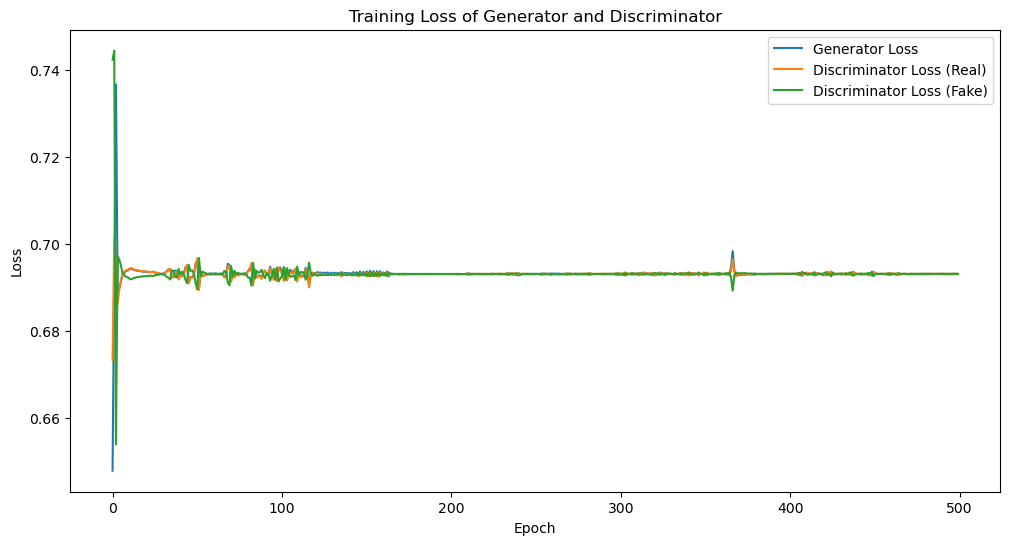

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(histG, label='Generator Loss')
plt.plot(histD_real, label='Discriminator Loss (Real)')
plt.plot(histD_fake, label='Discriminator Loss (Fake)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss of Generator and Discriminator')

# Save the plot as an image file
plt.savefig('training_loss_plot_C2.png', dpi=300)  # Specify the filename and resolution (dpi)

plt.show()

In [20]:
modelG.trainable = False

pred_y_train = modelG(train_x_slide)
pred_y_test = modelG(test_x_slide)

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.numpy())

Test dataset RMSE: 814.25
Test dataset MAPE: 2.16%
Test dataset R2: 0.9895


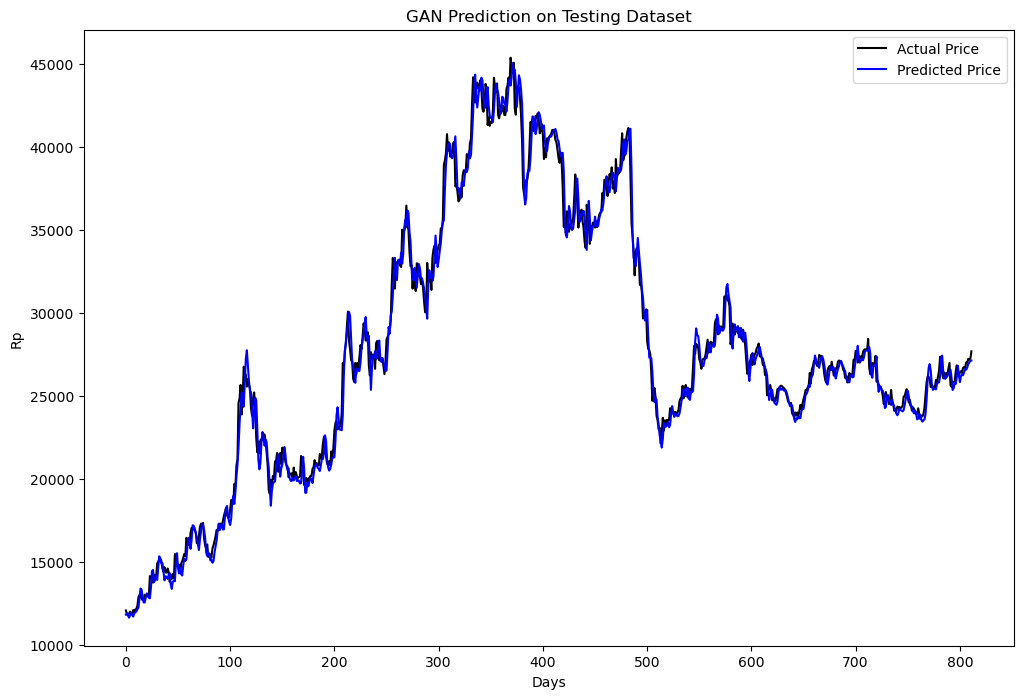

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color='black', label='Actual Price')
plt.plot(y_test_pred, color='blue', label='Predicted Price')
plt.title('GAN Prediction on Testing Dataset')
plt.ylabel('Rp')
plt.xlabel('Days')
plt.legend(loc='upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)

MAPE = mean_absolute_percentage_error(y_test_true, y_test_pred) * 100
r2 = r2_score(y_test_true, y_test_pred)

print(f'Test dataset RMSE: {RMSE}')
print(f'Test dataset MAPE: {MAPE:.2f}%')
print(f'Test dataset R2: {r2:.4f}')

plt.show()

Train dataset RMSE: 857.8078893318714
Train dataset MAPE: 2.67%
Train dataset R2: 0.9950


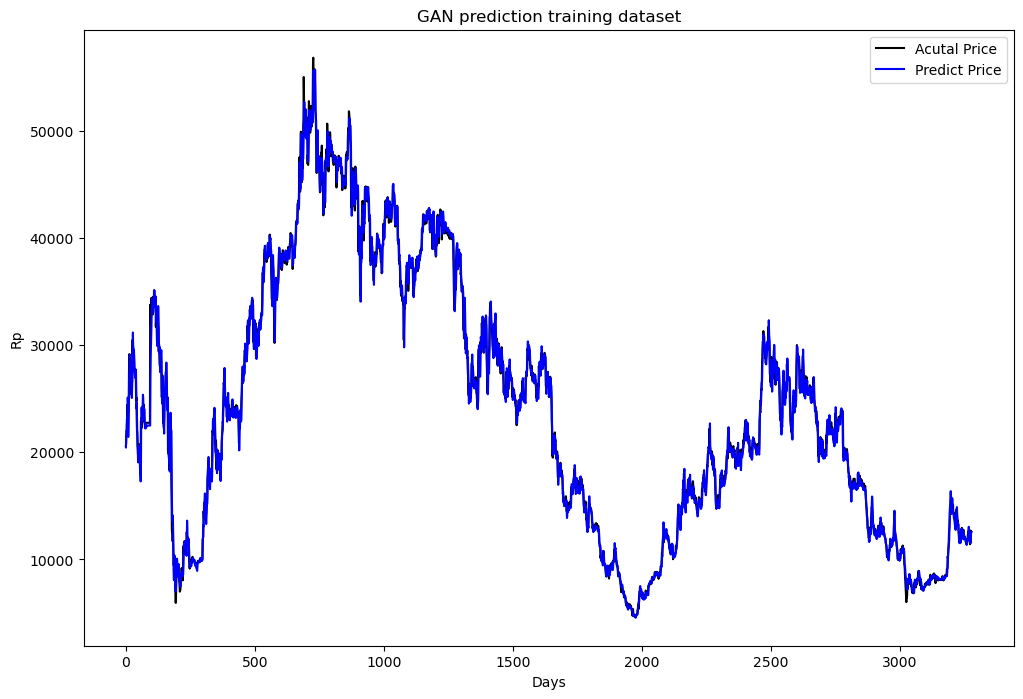

In [22]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction training dataset')
plt.ylabel('Rp')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
MAPE = mean_absolute_percentage_error(y_train_true, y_train_pred) * 100
r2 = r2_score(y_train_true, y_train_pred)

print(f'Train dataset RMSE: {RMSE}')
print(f'Train dataset MAPE: {MAPE:.2f}%')
print(f'Train dataset R2: {r2:.4f}')

plt.show()

In [23]:
MSE_train = mean_squared_error(y_train_true, y_train_pred)
RMSE_train = math.sqrt(MSE_train)
MAPE_train = mean_absolute_percentage_error(y_train_true, y_train_pred) * 100

MSE_test = mean_squared_error(y_test_true, y_test_pred)
RMSE_test = math.sqrt(MSE_test)
MAPE_test = mean_absolute_percentage_error(y_test_true, y_test_pred) * 100

result = {
    'RMSE_train': RMSE_train,
    'MAPE_train': MAPE_train,
    'RMSE_test': RMSE_test,
    'MAPE_test': MAPE_test,
}

with open('model_evaluation_C2.json', 'w') as json_file:
    json.dump(result, json_file, indent=4)

In [24]:
modelG.save('A4_B3_C2_Best.h5')

In [25]:
results_df = pd.DataFrame({
    'Actual Price': y_test_true.flatten(),
    'Predicted Price': y_test_pred.flatten()
})

results_df['Difference'] = abs(results_df['Actual Price'] - results_df['Predicted Price'])

results_df

,Actual Price,Predicted Price,Difference
0,12075.0,11821.271484,253.728516
1,11850.0,11903.934570,53.934570
2,11775.0,11804.866211,29.866211
3,11900.0,11638.603516,261.396484
4,12000.0,11787.935547,212.064453
...,...,...,...
807,27000.0,26694.304688,305.695312
808,27225.0,26916.382812,308.617188
809,27175.0,26991.041016,183.958984
810,27225.0,27110.972656,114.027344


In [26]:
smallest_diff = results_df['Difference'].min()
largest_diff = results_df['Difference'].max()

smallest_diff_row = results_df[results_df['Difference'] == smallest_diff]
largest_diff_row = results_df[results_df['Difference'] == largest_diff]

print("Smallest Difference:")
print(smallest_diff_row)

print("\nLargest Difference:")
print(largest_diff_row)


Smallest Difference:
     Actual Price  Predicted Price  Difference
721       25925.0     25924.498047    0.501953

Largest Difference:
     Actual Price  Predicted Price   Difference
420       35150.0     38550.613281  3400.613281


In [37]:
filtered_results = results_df[results_df['Difference'] < 50]
total_rows = len(results_df)
percentage = (len(filtered_results)/total_rows) * 100
print(f"Under Rp1000 diff: {percentage: .2f}%")
filtered_results

Under Rp1000 diff:  6.53%


,Actual Price,Predicted Price,Difference
2,11775.000000,11804.866211,29.866211
21,12975.000000,12937.320312,37.679688
29,14100.000000,14132.634766,32.634766
33,15200.000000,15165.049805,34.950195
36,14400.000000,14440.482422,40.482422
67,16750.000000,16762.437500,12.437500
88,16875.000000,16912.804688,37.804688
96,18250.000000,18214.544922,35.455078
154,20825.000000,20789.361328,35.638672
160,20000.001953,20027.347656,27.345703


In [35]:
import numpy as np
import pandas as pd

# Exclude 'Close' from features in last_sequence
features = df[['Open', 'High', 'Low', 'Adj Close', 'Volume']].values.astype(np.float32)
target = df[['Close']].values.astype(np.float32)  # Target remains as 'Close'

predictions = []
dates = []

last_date = pd.to_datetime(df['Date'].iloc[-1])

# Prepare the last input sequence without 'Close' for prediction
last_sequence = test_x_slide[-1]  # Removes the 'Close' column from last_sequence

for _ in range(10):
    # Reshape input sequence to fit model input shape
    input_sequence = last_sequence.reshape(1, *last_sequence.shape)

    # Make the prediction
    next_prediction = modelG.predict(input_sequence)
    predicted_close_price = next_prediction[0, 0]
    predictions.append(predicted_close_price)

    # Update the last_sequence for the next prediction step
    new_sequence = np.copy(last_sequence)
    new_sequence = np.roll(new_sequence, -1, axis=0)  # Shift sequence
    new_sequence[-1, :] = np.append(next_prediction, last_sequence[-1, 1:])  # Add prediction and retain feature order

    last_sequence = new_sequence  # Update sequence

    # Calculate the next weekday date
    next_date = last_date + pd.Timedelta(days=1)
    while next_date.weekday() >= 5:  # Skip weekends
        next_date += pd.Timedelta(days=1)

    dates.append(next_date)
    last_date = next_date

# Scale back predictions
future_predictions_scaled_back = y_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Create DataFrame with predictions
predictions_df = pd.DataFrame({
    'Date': dates,
    'Predicted Close': future_predictions_scaled_back.flatten()})

predictions_df


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


,Date,Predicted Close
0,2024-09-03,27120.292969
1,2024-09-04,27035.093750
2,2024-09-05,27021.621094
3,2024-09-06,27021.642578
4,2024-09-09,27029.251953
5,2024-09-10,27037.056641
6,2024-09-11,27063.710938
7,2024-09-12,27034.472656
8,2024-09-13,27036.021484
9,2024-09-16,27036.585938
